# 1-2: Feature Engineering

## 학습 목표
- Feature Engineering이 무엇인지 이해
- 시간, 금액, 집계 피처 생성 방법 학습
- 범주형 인코딩 이해
- XGBoost에 넣을 데이터 준비

## 이 노트북에서 할 것
```
train.csv (1-1에서 만든 것)
    ↓ Feature Engineering
train_features.csv (XGBoost용)
```

In [1]:
# 패키지 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 경로 설정
DATA_PROCESSED = Path('../../data/processed')

print("패키지 로드 완료!")

패키지 로드 완료!


---

## 📚 Feature Engineering이란?

### 개념
원본 데이터를 **모델이 더 잘 학습할 수 있는 형태로 변환**하는 것

### 왜 필요해?
```
원본: TransactionDT = 86400 (그냥 숫자, 의미 없음)
    ↓
변환: hour = 0 (자정!)
      is_night = True (밤이네!)
    ↓
모델: "밤에 거래하면 사기 확률이 높구나!" 학습 가능
```

### FDS에서 중요한 피처들
| 종류 | 예시 | 왜 중요? |
|------|------|----------|
| 시간 | hour, is_night | 밤 거래는 사기 확률 높음 |
| 금액 | amt_log | 이상하게 큰 금액 탐지 |
| 집계 | card1_count | 갑자기 거래 폭증하면 의심 |
| 범주형 | ProductCD | 특정 상품 카테고리가 위험 |

---

## 섹션 1: 데이터 로드

In [2]:
# 1-1에서 만든 데이터 로드
train_df = pd.read_csv(DATA_PROCESSED / 'train.csv')
test_df = pd.read_csv(DATA_PROCESSED / 'test.csv')

print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")
print(f"\n컬럼 수: {len(train_df.columns)}")

Train: (472432, 434)
Test: (118108, 434)

컬럼 수: 434


In [ ]:
# 주요 컬럼 확인
print("주요 컬럼들:")
print(train_df[['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1']].head())

---

## 📚 시간 피처 (Time Features)

### TransactionDT란?
- 데이터셋 시작 시점부터 **경과한 초(seconds)**
- 예: `TransactionDT = 86400` → 시작점에서 1일(86400초) 후

### 만들 피처들
| 피처 | 설명 | 공식 |
|------|------|------|
| hour | 거래 시각 (0~23) | `(TransactionDT // 3600) % 24` |
| dayofweek | 요일 (0=월, 6=일) | `(TransactionDT // 86400) % 7` |
| is_weekend | 주말 여부 | `dayofweek >= 5` |
| is_night | 밤 (22~6시) | `(hour >= 22) or (hour <= 6)` |

### 왜 이렇게 계산해?
```
1시간 = 3600초
1일 = 86400초 (= 24 * 3600)

예: TransactionDT = 90000
- 몇 시? → 90000 // 3600 = 25시간 → 25 % 24 = 1시
- 무슨 요일? → 90000 // 86400 = 1일 → 1 % 7 = 월요일(1)
```

## 섹션 2: 시간 피처 생성

In [8]:
# 예제: 시간 피처 생성 함수
def create_time_features(df):
    """시간 관련 피처 생성"""
    df = df.copy()
    
    # 시간 (0~23)
    df['hour'] = (df['TransactionDT'] // 3600) % 24
    
    # 요일 (0=월요일, 6=일요일)
    df['dayofweek'] = (df['TransactionDT'] // 86400) % 7
    
    # 주말 여부
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # 밤 시간 (22시~6시)
    df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
    
    return df

# 예제 적용
sample = train_df[['TransactionDT']].head(5).copy()
sample = create_time_features(sample)
print(sample)

   TransactionDT  hour  dayofweek  is_weekend  is_night
0          86400     0          1           0         1
1          86401     0          1           0         1
2          86469     0          1           0         1
3          86499     0          1           0         1
4          86506     0          1           0         1


### 💻 실습 2: 시간 피처 생성

train_df와 test_df에 시간 피처를 추가하세요.

In [ ]:
# 💻 실습: 시간 피처 직접 만들기
# 힌트: 1시간 = 3600초, 1일 = 86400초

# TODO: hour 만들기 - TransactionDT를 3600으로 나눈 몫의 24 나머지
train_df['hour'] = (train_df['TransactionDT'] // 3600) % 24
# TODO: dayofweek 만들기 - TransactionDT를 86400으로 나눈 몫의 7 나머지
train_df['dayofweek'] = (train_df['TransactionDT'] // 86400) % 7
# TODO: is_weekend 만들기 - dayofweek가 5 이상이면 1, 아니면 0
train_df['is_weekend'] = (train_df['dayofweek'] >= 5).astype(int)
# TODO: is_night 만들기 - hour가 22 이상이거나 6 이하면 1
train_df['is_night'] = ((train_df['hour'] >= 22) | (train_df['hour'] <= 6)).astype(int)

# test_df도 동일하게!

In [17]:
# ✅ 실습 정답
train_df['hour'] = (train_df['TransactionDT'] // 3600) % 24
train_df['dayofweek'] = (train_df['TransactionDT'] // 86400) % 7
train_df['is_weekend'] = (train_df['dayofweek'] >= 5).astype(int)
train_df['is_night'] = ((train_df['hour'] >= 22) | (train_df['hour'] <= 6)).astype(int)

# test_df도 동일하게
test_df['hour'] = (test_df['TransactionDT'] // 3600) % 24
test_df['dayofweek'] = (test_df['TransactionDT'] // 86400) % 7
test_df['is_weekend'] = (test_df['dayofweek'] >= 5).astype(int)
test_df['is_night'] = ((test_df['hour'] >= 22) | (test_df['hour'] <= 6)).astype(int)

print("시간 피처 추가 완료!")
print(train_df[['TransactionDT', 'hour', 'dayofweek', 'is_weekend', 'is_night']].head())

시간 피처 추가 완료!
   TransactionDT  hour  dayofweek  is_weekend  is_night
0          86400     0          1           0         1
1          86401     0          1           0         1
2          86469     0          1           0         1
3          86499     0          1           0         1
4          86506     0          1           0         1


In [18]:
# 체크포인트
assert 'hour' in train_df.columns, "hour 컬럼이 없습니다!"
assert 'dayofweek' in train_df.columns, "dayofweek 컬럼이 없습니다!"
assert train_df['hour'].min() >= 0 and train_df['hour'].max() <= 23, "hour 범위 오류!"
assert train_df['dayofweek'].min() >= 0 and train_df['dayofweek'].max() <= 6, "dayofweek 범위 오류!"
print("✅ 시간 피처 체크 통과!")

✅ 시간 피처 체크 통과!


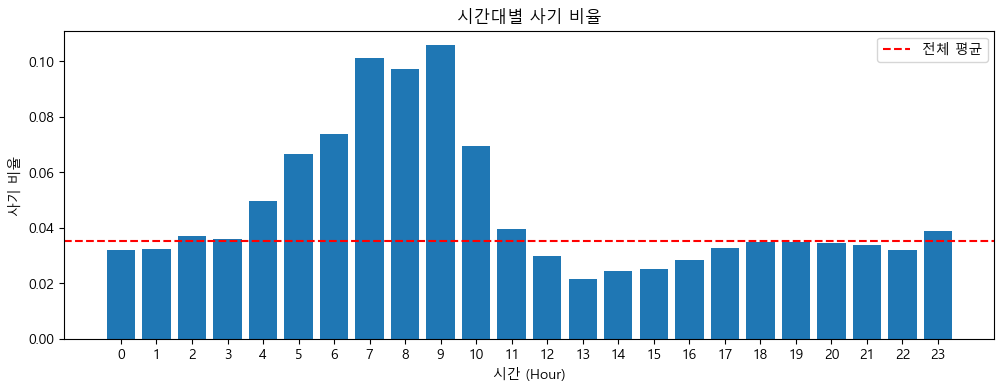

→ 특정 시간대에 사기가 더 많이 발생하는 패턴이 보이나요?


In [13]:
# 시간대별 사기 비율 시각화
hourly_fraud = train_df.groupby('hour')['isFraud'].mean()

plt.figure(figsize=(12, 4))
plt.bar(hourly_fraud.index, hourly_fraud.values)
plt.xlabel('시간 (Hour)')
plt.ylabel('사기 비율')
plt.title('시간대별 사기 비율')
plt.xticks(range(0, 24))
plt.axhline(y=train_df['isFraud'].mean(), color='r', linestyle='--', label='전체 평균')
plt.legend()
plt.show()

print("→ 특정 시간대에 사기가 더 많이 발생하는 패턴이 보이나요?")

---

## 📚 금액 피처 (Amount Features)

### 왜 변환이 필요해?
```
TransactionAmt 범위: $0.01 ~ $31,937
→ 값 차이가 너무 큼
→ 로그 변환으로 압축!
```

### 만들 피처들
| 피처 | 설명 | 왜 유용? |
|------|------|----------|
| amt_log | log(1+금액) | 큰 값 압축, 분포 정규화 |
| amt_decimal | 소수점 부분 | $99.99 같은 패턴 탐지 |
| amt_bin | 금액 구간 (0~3) | 소액/중액/고액/초고액 구분 |

### log1p란?
```python
np.log1p(x) = np.log(1 + x)

왜 1을 더해? → x=0일 때 log(0) = -무한대 방지!
```

## 섹션 3: 금액 피처 생성

In [14]:
# 예제: 금액 피처 생성 함수
def create_amount_features(df):
    """금액 관련 피처 생성"""
    df = df.copy()
    
    # 로그 변환 (큰 값 압축)
    df['amt_log'] = np.log1p(df['TransactionAmt'])
    
    # 소수점 부분 (99.99 같은 패턴)
    df['amt_decimal'] = df['TransactionAmt'] % 1
    
    # 금액 구간화
    # 0: ~50, 1: 50~200, 2: 200~500, 3: 500~
    df['amt_bin'] = pd.cut(
        df['TransactionAmt'],
        bins=[0, 50, 200, 500, np.inf],
        labels=[0, 1, 2, 3]
    ).astype(float)
    
    return df

# 예제: 로그 변환 효과
amounts = [1, 10, 100, 1000, 10000]
for amt in amounts:
    print(f"금액: {amt:>6} → 로그: {np.log1p(amt):.2f}")

금액:      1 → 로그: 0.69
금액:     10 → 로그: 2.40
금액:    100 → 로그: 4.62
금액:   1000 → 로그: 6.91
금액:  10000 → 로그: 9.21


### 💻 실습 3: 금액 피처 생성

train_df와 test_df에 금액 피처를 추가하세요.

In [ ]:
# 💻 실습: 금액 피처 직접 만들기

# TODO: amt_log 만들기 - np.log1p() 사용 (log(1+x))
train_df['amt_log'] = np.log1p(train_df['TransactionAmt'])

# TODO: amt_decimal 만들기 - 소수점 부분만 추출 (% 1 사용)
train_df['amt_decimal'] = train_df['TransactionAmt'] % 1

# TODO: amt_bin 만들기 - pd.cut() 사용
# 구간: 0~50 → 0, 50~200 → 1, 200~500 → 2, 500~ → 3
train_df['amt_bin'] = pd.cut(
    train_df['TransactionAmt'],
    bins=[0, 50, 200, 500, np.inf],
    labels=[0, 1, 2, 3]
).astype(float)

# test_df도 동일하게!

In [19]:
# ✅ 실습 정답
train_df['amt_log'] = np.log1p(train_df['TransactionAmt'])
train_df['amt_decimal'] = train_df['TransactionAmt'] % 1
train_df['amt_bin'] = pd.cut(
    train_df['TransactionAmt'],
    bins=[0, 50, 200, 500, np.inf],
    labels=[0, 1, 2, 3]
).astype(float)

# test_df도 동일하게
test_df['amt_log'] = np.log1p(test_df['TransactionAmt'])
test_df['amt_decimal'] = test_df['TransactionAmt'] % 1
test_df['amt_bin'] = pd.cut(
    test_df['TransactionAmt'],
    bins=[0, 50, 200, 500, np.inf],
    labels=[0, 1, 2, 3]
).astype(float)

print("금액 피처 추가 완료!")
print(train_df[['TransactionAmt', 'amt_log', 'amt_decimal', 'amt_bin']].head(10))

금액 피처 추가 완료!
   TransactionAmt   amt_log  amt_decimal  amt_bin
0            68.5  4.241327          0.5      1.0
1            29.0  3.401197          0.0      0.0
2            59.0  4.094345          0.0      1.0
3            50.0  3.931826          0.0      0.0
4            50.0  3.931826          0.0      0.0
5            49.0  3.912023          0.0      0.0
6           159.0  5.075174          0.0      1.0
7           422.5  6.048554          0.5      2.0
8            15.0  2.772589          0.0      0.0
9           117.0  4.770685          0.0      1.0


In [20]:
# 체크포인트
assert 'amt_log' in train_df.columns, "amt_log 컬럼이 없습니다!"
assert 'amt_decimal' in train_df.columns, "amt_decimal 컬럼이 없습니다!"
assert train_df['amt_decimal'].min() >= 0 and train_df['amt_decimal'].max() < 1, "amt_decimal 범위 오류!"
print("✅ 금액 피처 체크 통과!")

✅ 금액 피처 체크 통과!


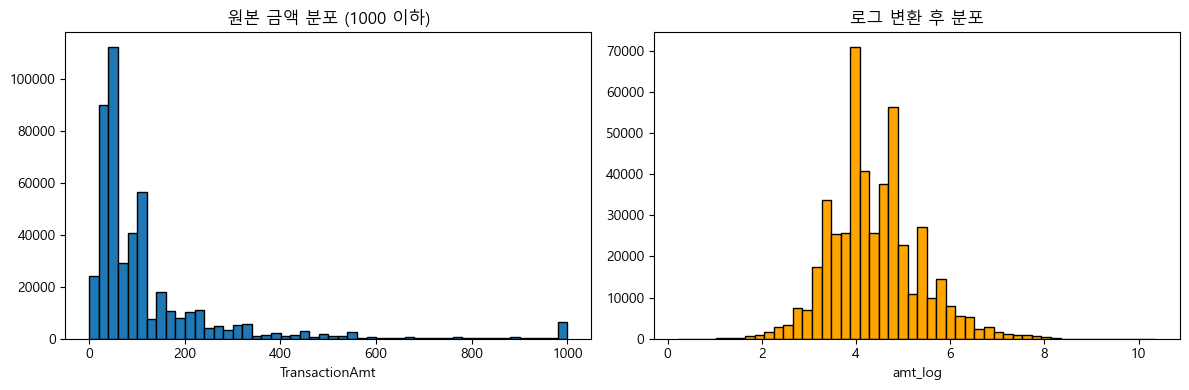

→ 로그 변환 후 분포가 더 정규분포에 가까워졌나요?


In [24]:
# 로그 변환 전/후 분포 비교
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 원본
axes[0].hist(train_df['TransactionAmt'].clip(upper=1000), bins=50, edgecolor='black')
axes[0].set_title('원본 금액 분포 (1000 이하)')
axes[0].set_xlabel('TransactionAmt')

# 로그 변환 후
axes[1].hist(train_df['amt_log'], bins=50, edgecolor='black', color='orange')
axes[1].set_title('로그 변환 후 분포')
axes[1].set_xlabel('amt_log')

plt.tight_layout()
plt.show()

print("→ 로그 변환 후 분포가 더 정규분포에 가까워졌나요?")

---

## 📚 집계 피처 (Aggregation Features)

### 아이디어
```
card1 = 카드 식별자

질문: "이 카드로 몇 번 거래했지?"
      "이 카드의 평균 거래 금액은?"

→ 갑자기 평소보다 많이 거래하거나
  평균보다 훨씬 큰 금액이면 → 사기 의심!
```

### 만들 피처들
| 피처 | 설명 |
|------|------|
| card1_count | 해당 카드의 총 거래 횟수 |
| card1_amt_mean | 해당 카드의 평균 거래 금액 |
| card1_amt_std | 해당 카드의 거래 금액 표준편차 |

### 주의: Data Leakage
```
train에서 계산한 통계를 test에도 적용해야 함!
test만의 통계를 따로 계산하면 안 됨!
```

## 섹션 4: 집계 피처 생성

In [25]:
# 예제: card1별 통계 계산
card1_stats = train_df.groupby('card1')['TransactionAmt'].agg(['count', 'mean', 'std'])
card1_stats.columns = ['card1_count', 'card1_amt_mean', 'card1_amt_std']
card1_stats = card1_stats.reset_index()

print("card1별 통계 (상위 10개):")
print(card1_stats.sort_values('card1_count', ascending=False).head(10))

card1별 통계 (상위 10개):
       card1  card1_count  card1_amt_mean  card1_amt_std
5032    7919        12205      101.211504     116.440920
6200    9500        11138      115.451750     193.992124
10870  15885         8488       39.773405      36.139983
11841  17188         8214      132.682482     193.193669
10257  15066         6266      208.671529     315.021648
3643    6019         5687      218.662539     395.642553
8561   12695         5564      140.269643     201.908929
8446   12544         5367      109.241862     144.462318
1317    2803         4879      143.442858     261.815949
4789    7585         4416      197.820234     286.170673


In [26]:
# 예제: 집계 피처 생성 함수
def create_agg_features(train_df, test_df):
    """
    집계 피처 생성
    주의: train에서 계산한 통계를 train/test 모두에 적용!
    """
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    # train에서 card1별 통계 계산
    card1_stats = train_df.groupby('card1')['TransactionAmt'].agg(['count', 'mean', 'std'])
    card1_stats.columns = ['card1_count', 'card1_amt_mean', 'card1_amt_std']
    card1_stats = card1_stats.reset_index()
    
    # train, test 모두에 붙이기
    train_df = train_df.merge(card1_stats, on='card1', how='left')
    test_df = test_df.merge(card1_stats, on='card1', how='left')
    
    # 결측치 처리 (train에 없는 card1이 test에 있을 수 있음)
    for col in ['card1_count', 'card1_amt_mean', 'card1_amt_std']:
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)
    
    return train_df, test_df

print("함수 정의 완료!")

함수 정의 완료!


### 💻 실습 4: 집계 피처 생성

create_agg_features 함수를 사용해서 집계 피처를 추가하세요.

In [27]:
# 💻 실습: 집계 피처 직접 만들기

# 1단계: train에서 card1별 통계 계산
# TODO: groupby + agg로 count, mean, std 계산
card1_stats = train_df.groupby('card1')['TransactionAmt'].agg(['count', 'mean', 'std'])
card1_stats.columns = ['card1_count', 'card1_amt_mean', 'card1_amt_std']
card1_stats = card1_stats.reset_index()

# 2단계: train, test에 붙이기
# TODO: merge 사용 (on='card1', how='left')
train_df = train_df.merge(card1_stats, on='card1', how='left')
test_df = test_df.merge(card1_stats, on='card1', how='left')

# 3단계: 결측치 처리
# test에 train에 없는 card1이 있을 수 있음 → 0으로 채우기

In [30]:
# ✅ 실습 정답

# 1단계: train에서 card1별 통계 계산
card1_stats = train_df.groupby('card1')['TransactionAmt'].agg(['count', 'mean', 'std'])
card1_stats.columns = ['card1_count', 'card1_amt_mean', 'card1_amt_std']
card1_stats = card1_stats.reset_index()

# 2단계: train, test에 붙이기
train_df = train_df.merge(card1_stats, on='card1', how='left')
test_df = test_df.merge(card1_stats, on='card1', how='left')

# 3단계: 결측치 처리
for col in ['card1_count', 'card1_amt_mean', 'card1_amt_std']:
    train_df[col] = train_df[col].fillna(0)
    test_df[col] = test_df[col].fillna(0)

print("집계 피처 추가 완료!")
print(train_df[['card1', 'card1_count', 'card1_amt_mean', 'card1_amt_std']].head(10))

집계 피처 추가 완료!
   card1  card1_count  card1_amt_mean  card1_amt_std
0  13926           42      353.869762     375.419688
1   2755          570      235.623018     481.888744
2   4663          886       93.583296      98.886510
3  18132         3383      123.557544     186.493777
4   4497           13       94.123077      54.254203
5   5937            6      148.250000     101.257963
6  12308          183      102.127650     184.859159
7  12695         5564      140.269643     201.908929
8   2803         4879      143.442858     261.815949
9  17399         1499      121.985554     183.757915


In [31]:
# 체크포인트
assert 'card1_count' in train_df.columns, "card1_count 컬럼이 없습니다!"
assert 'card1_amt_mean' in train_df.columns, "card1_amt_mean 컬럼이 없습니다!"
assert train_df['card1_count'].isna().sum() == 0, "card1_count에 결측치가 있습니다!"
print("✅ 집계 피처 체크 통과!")

✅ 집계 피처 체크 통과!


---

## 📚 범주형 인코딩 (Categorical Encoding)

### 왜 필요해?
```
ProductCD = ['W', 'H', 'C', 'S', 'R']

모델은 문자를 이해 못함! → 숫자로 변환

LabelEncoder: W→0, H→1, C→2, S→3, R→4
```

### 대상 컬럼
- ProductCD: 상품 카테고리
- card4: 카드 종류 (visa, mastercard...)
- card6: 카드 타입 (debit, credit...)
- P_emaildomain: 구매자 이메일 도메인
- R_emaildomain: 수신자 이메일 도메인

### 주의사항
```
train에서 fit한 LabelEncoder를 test에도 적용!
test에 새로운 값이 있으면 → 'unknown'으로 처리
```

## 섹션 5: 범주형 인코딩

In [32]:
# 범주형 컬럼 확인
cat_cols = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain']

for col in cat_cols:
    if col in train_df.columns:
        unique_count = train_df[col].nunique()
        print(f"{col}: {unique_count}개 고유값")
        print(f"  예시: {train_df[col].dropna().unique()[:5]}")

ProductCD: 5개 고유값
  예시: ['W' 'H' 'C' 'S' 'R']
card4: 4개 고유값
  예시: ['discover' 'mastercard' 'visa' 'american express']
card6: 4개 고유값
  예시: ['credit' 'debit' 'debit or credit' 'charge card']
P_emaildomain: 59개 고유값
  예시: ['gmail.com' 'outlook.com' 'yahoo.com' 'mail.com' 'anonymous.com']
R_emaildomain: 60개 고유값
  예시: ['gmail.com' 'hotmail.com' 'anonymous.com' 'outlook.com' 'charter.net']


In [33]:
# 예제: 범주형 인코딩 함수
def encode_categoricals(train_df, test_df, cat_cols):
    """
    범주형 컬럼을 숫자로 변환
    train에서 fit한 encoder를 test에도 적용
    """
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    encoders = {}  # 나중에 저장용
    
    for col in cat_cols:
        if col not in train_df.columns:
            continue
            
        # 결측치를 'unknown'으로 채우기
        train_df[col] = train_df[col].fillna('unknown').astype(str)
        test_df[col] = test_df[col].fillna('unknown').astype(str)
        
        # train의 모든 값 + 'unknown' 으로 encoder 학습
        le = LabelEncoder()
        all_values = list(train_df[col].unique()) + ['unknown']
        le.fit(all_values)
        
        # test에 train에 없는 값이 있으면 'unknown'으로 대체
        test_df[col] = test_df[col].apply(
            lambda x: x if x in le.classes_ else 'unknown'
        )
        
        # 변환
        train_df[col] = le.transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
        
        encoders[col] = le
        print(f"{col}: 인코딩 완료 (0~{len(le.classes_)-1})")
    
    return train_df, test_df, encoders

print("함수 정의 완료!")

함수 정의 완료!


### 💻 실습 5: 범주형 인코딩

encode_categoricals 함수를 사용해서 범주형 컬럼을 숫자로 변환하세요.

In [ ]:
# 💻 실습: 범주형 인코딩 직접 하기

# 모든 object 타입 컬럼 찾기
# TODO: select_dtypes로 object 컬럼 찾기
# cat_cols = train_df.select_dtypes(include=['???']).columns.tolist()

encoders = {}

for col in cat_cols:
    # TODO 1: 결측치를 'unknown'으로 채우기
    # train_df[col] = train_df[col].fillna('???').astype(str)
    # test_df[col] = test_df[col].fillna('???').astype(str)
    
    # TODO 2: LabelEncoder 생성 및 학습
    # le = LabelEncoder()
    # all_values = list(train_df[col].unique()) + ['unknown']
    # le.fit(???)
    
    # TODO 3: 변환 적용
    # train_df[col] = le.transform(train_df[col])
    
    # TODO 4: test에 train에 없는 값 처리 후 변환
    # test_df[col] = test_df[col].apply(lambda x: x if x in le.classes_ else 'unknown')
    # test_df[col] = le.transform(test_df[col])
    
    pass

print("범주형 인코딩 실습을 완성하세요!")

In [ ]:
# ✅ 실습 정답 - 모든 object 컬럼 인코딩

# 모든 object 타입 컬럼 찾기
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print(f"인코딩할 컬럼 수: {len(cat_cols)}")

encoders = {}

for col in cat_cols:
    # 1. 결측치를 'unknown'으로 채우기
    train_df[col] = train_df[col].fillna('unknown').astype(str)
    test_df[col] = test_df[col].fillna('unknown').astype(str)
    
    # 2. LabelEncoder 생성 및 학습
    le = LabelEncoder()
    all_values = list(train_df[col].unique()) + ['unknown']
    le.fit(all_values)
    
    # 3. train 변환
    train_df[col] = le.transform(train_df[col])
    
    # 4. test: train에 없는 값은 'unknown'으로 대체 후 변환
    test_df[col] = test_df[col].apply(lambda x: x if x in le.classes_ else 'unknown')
    test_df[col] = le.transform(test_df[col])
    
    encoders[col] = le

print(f"\n{len(cat_cols)}개 컬럼 인코딩 완료!")
print(f"예시: {list(cat_cols)[:5]}")

In [ ]:
# 체크포인트
# 모든 컬럼이 수치형이어야 함 (object 없어야 함)
obj_cols_remaining = train_df.select_dtypes(include=['object']).columns.tolist()
assert len(obj_cols_remaining) == 0, f"아직 object 컬럼이 있습니다: {obj_cols_remaining}"
print(f"✅ 범주형 인코딩 체크 통과! ({len(cat_cols)}개 컬럼 인코딩됨)")

---

## 📚 결측치 처리

### 전략
| 타입 | 처리 방법 | 이유 |
|------|-----------|------|
| 수치형 | 중앙값(median) | 평균보다 이상치에 강함 |
| 범주형 | 이미 'unknown'으로 처리됨 | - |

### 왜 평균 말고 중앙값?
```
금액: [10, 10, 10, 10, 10000]
- 평균: 2008 (이상치 때문에 높음)
- 중앙값: 10 (실제 대부분의 값)
```

## 섹션 6: 결측치 처리

In [37]:
# 현재 결측치 상태 확인
train_missing = train_df.isnull().sum()
train_missing = train_missing[train_missing > 0].sort_values(ascending=False)

print(f"결측치가 있는 컬럼 수: {len(train_missing)}")
print(f"\n상위 10개:")
print(train_missing.head(10))

결측치가 있는 컬럼 수: 412

상위 10개:
id_24    468518
id_25    468186
id_08    468171
id_07    468171
id_21    468169
id_26    468165
id_22    468159
id_23    468159
id_27    468159
D7       442488
dtype: int64


In [38]:
# 예제: 결측치 처리 함수
def fill_missing(train_df, test_df):
    """
    결측치 처리
    - 수치형: train의 중앙값으로 채우기
    """
    train_df = train_df.copy()
    test_df = test_df.copy()
    
    # 수치형 컬럼만 선택
    num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
    
    # train의 중앙값 계산
    medians = train_df[num_cols].median()
    
    # train, test 모두 같은 중앙값으로 채우기
    train_df[num_cols] = train_df[num_cols].fillna(medians)
    test_df[num_cols] = test_df[num_cols].fillna(medians)
    
    return train_df, test_df, medians

print("함수 정의 완료!")

함수 정의 완료!


### 💻 실습 6: 결측치 처리

fill_missing 함수를 사용해서 결측치를 처리하세요.

In [40]:
# 💻 실습: 결측치 처리 직접 하기

# TODO 1: 수치형 컬럼만 선택
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

# TODO 2: train의 중앙값 계산
medians = train_df[num_cols].median()

# TODO 3: train, test 모두 같은 중앙값으로 채우기
train_df[num_cols] = train_df[num_cols].fillna(medians)
test_df[num_cols] = test_df[num_cols].fillna(medians)

In [49]:
# ✅ 실습 정답

# 1. 수치형 컬럼만 선택
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

# 2. train의 중앙값 계산
medians = train_df[num_cols].median()

# 3. train, test 모두 같은 중앙값으로 채우기
train_df[num_cols] = train_df[num_cols].fillna(medians)
test_df[num_cols] = test_df[num_cols].fillna(medians)

print("결측치 처리 완료!")
print(f"남은 결측치: {train_df.isnull().sum().sum()}개")

결측치 처리 완료!
남은 결측치: 8707824개


In [48]:
# 체크포인트
assert train_df[num_cols].isnull().sum().sum() == 0, "train에 결측치가 남아있습니다!"
assert test_df[num_cols].isnull().sum().sum() == 0, "test에 결측치가 남아있습니다!"
print("✅ 결측치 처리 체크 통과!")

✅ 결측치 처리 체크 통과!


---

## 섹션 7: 피처 선택 및 저장

In [50]:
# 현재 컬럼 확인
print(f"현재 컬럼 수: {len(train_df.columns)}")
print(f"\n컬럼 목록:")
print(train_df.columns.tolist())

현재 컬럼 수: 450

컬럼 목록:
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V

In [51]:
# 학습에 사용할 피처 선택
# 제외할 컬럼: ID, 타겟, 원본 시간
exclude_cols = ['TransactionID', 'isFraud', 'TransactionDT']

# 사용할 피처
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

print(f"사용할 피처 수: {len(feature_cols)}")
print(f"\n새로 만든 피처들:")
new_features = ['hour', 'dayofweek', 'is_weekend', 'is_night', 
                'amt_log', 'amt_decimal', 'amt_bin',
                'card1_count', 'card1_amt_mean', 'card1_amt_std']
for f in new_features:
    if f in feature_cols:
        print(f"  ✓ {f}")

사용할 피처 수: 447

새로 만든 피처들:
  ✓ hour
  ✓ dayofweek
  ✓ is_weekend
  ✓ is_night
  ✓ amt_log
  ✓ amt_decimal
  ✓ amt_bin
  ✓ card1_count
  ✓ card1_amt_mean
  ✓ card1_amt_std


In [ ]:
# 최종 데이터 준비
X_train = train_df[feature_cols]
y_train = train_df['isFraud']

X_test = test_df[feature_cols]
y_test = test_df['isFraud']

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

In [ ]:
# 저장
# 피처 + 타겟 함께 저장
train_features = train_df[feature_cols + ['isFraud']]
test_features = test_df[feature_cols + ['isFraud']]

train_features.to_csv(DATA_PROCESSED / 'train_features.csv', index=False)
test_features.to_csv(DATA_PROCESSED / 'test_features.csv', index=False)

print("저장 완료!")
print(f"  train_features.csv: {train_features.shape}")
print(f"  test_features.csv: {test_features.shape}")

In [ ]:
# 피처 목록도 저장 (나중에 필요)
import json

feature_info = {
    'feature_cols': feature_cols,
    'new_features': new_features,
    'cat_cols': cat_cols,
}

with open(DATA_PROCESSED / 'feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)

print("feature_info.json 저장 완료!")

In [ ]:
# 최종 체크포인트
import os

assert os.path.exists(DATA_PROCESSED / 'train_features.csv'), "train_features.csv가 없습니다!"
assert os.path.exists(DATA_PROCESSED / 'test_features.csv'), "test_features.csv가 없습니다!"
assert os.path.exists(DATA_PROCESSED / 'feature_info.json'), "feature_info.json이 없습니다!"

# 저장된 파일 확인
saved_train = pd.read_csv(DATA_PROCESSED / 'train_features.csv')
assert 'isFraud' in saved_train.columns, "isFraud 컬럼이 없습니다!"
assert 'hour' in saved_train.columns, "hour 컬럼이 없습니다!"

print("✅ 모든 체크 통과!")
print("\n1-2 Feature Engineering 완료!")

---

## 📝 요약

### 이 노트북에서 한 것
1. **시간 피처**: hour, dayofweek, is_weekend, is_night
2. **금액 피처**: amt_log, amt_decimal, amt_bin
3. **집계 피처**: card1_count, card1_amt_mean, card1_amt_std
4. **범주형 인코딩**: ProductCD, card4, card6 등
5. **결측치 처리**: 중앙값으로 채우기

### 산출물
- `data/processed/train_features.csv`
- `data/processed/test_features.csv`
- `data/processed/feature_info.json`

### 다음 단계
→ **1-3 XGBoost**: 모델 학습!

---

## 🎯 면접 포인트

**Q: Feature Engineering에서 가장 중요한 피처는?**
> "card1별 집계 피처(거래 횟수, 평균 금액)가 효과적이었습니다. 갑자기 거래 패턴이 바뀌면 사기일 가능성이 높기 때문입니다."

**Q: 왜 로그 변환을 했나요?**
> "거래 금액의 분포가 심하게 왜곡되어 있었습니다(1~31,937). 로그 변환으로 분포를 정규화하면 모델이 더 잘 학습합니다."

**Q: 범주형 인코딩에서 주의할 점은?**
> "train에서 fit한 encoder를 test에도 동일하게 적용해야 합니다. test에 새로운 값이 있으면 'unknown'으로 처리했습니다."